# Session 7: Stochastic Volatility Models

## Course: Advanced Volatility Modeling

---

## Learning Objectives

1. Understand stochastic volatility (SV) in continuous and discrete time
2. Compare SV to GARCH: key differences and implications
3. Estimate SV models using quasi-maximum likelihood
4. Explore the Heston model and affine structures

---

## 1. Stochastic Volatility: Core Idea

### 1.1 GARCH vs SV

**GARCH**: Volatility is deterministic given past returns:
$$\sigma_t^2 = f(\epsilon_{t-1}, \epsilon_{t-2}, ..., \sigma_{t-1}^2, ...)$$

**Stochastic Volatility**: Volatility has its **own source of randomness**:
$$\sigma_t^2 = g(h_t), \quad h_t = \alpha + \beta h_{t-1} + \sigma_\eta \eta_t$$

where $\eta_t$ is a shock **independent** of the return innovation.

### 1.2 Why Stochastic Volatility?

1. **More realistic**: Volatility can change even without large returns
2. **Option pricing**: Better fits option smile/skew
3. **Continuous-time foundation**: Natural extension of diffusions
4. **Separate risk factors**: Volatility risk can be priced separately

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
np.random.seed(42)

## 2. Discrete-Time SV Model

### 2.1 Basic Specification (Taylor, 1986)

$$y_t = \exp(h_t / 2) \epsilon_t, \quad \epsilon_t \sim N(0,1)$$
$$h_t = \mu + \phi(h_{t-1} - \mu) + \sigma_\eta \eta_t, \quad \eta_t \sim N(0,1)$$

where $y_t$ are returns and $h_t = \log(\sigma_t^2)$ is log-volatility.

**Parameters**:
- $\mu$: long-run mean of log-volatility
- $\phi$: persistence (should be < 1 for stationarity)
- $\sigma_\eta$: volatility of volatility

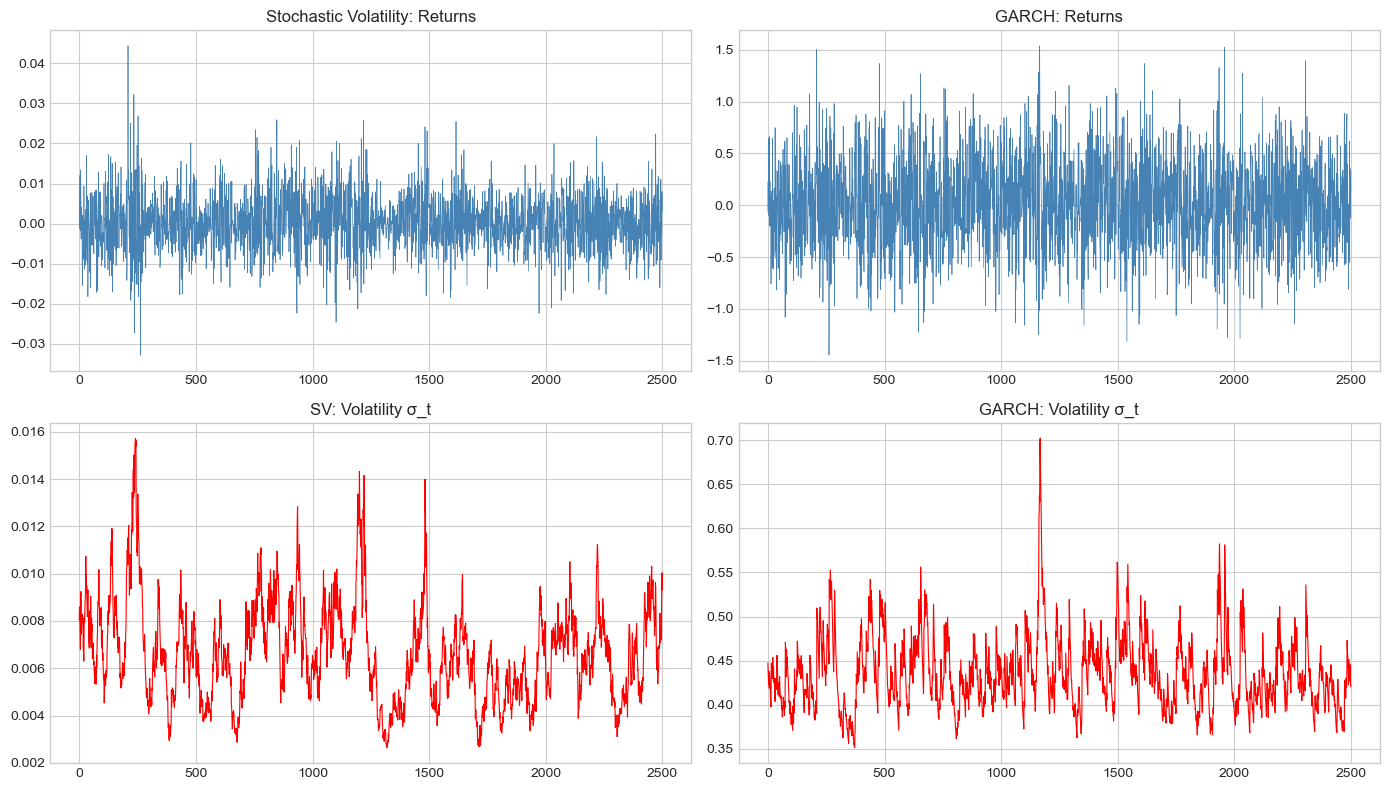

In [5]:
def simulate_sv(n, mu, phi, sigma_eta, seed=None):
    """
    Simulate discrete-time stochastic volatility model.
    
    y_t = exp(h_t/2) * eps_t
    h_t = mu + phi*(h_{t-1} - mu) + sigma_eta * eta_t
    """
    if seed is not None:
        np.random.seed(seed)
    
    h = np.zeros(n)
    y = np.zeros(n)
    
    eps = np.random.standard_normal(n)
    eta = np.random.standard_normal(n)
    
    # Initialize at unconditional mean
    h[0] = mu + sigma_eta * eta[0] / np.sqrt(1 - phi**2)
    y[0] = np.exp(h[0] / 2) * eps[0]
    
    for t in range(1, n):
        h[t] = mu + phi * (h[t-1] - mu) + sigma_eta * eta[t]
        y[t] = np.exp(h[t] / 2) * eps[t]
    
    return y, h

# Simulate SV process
n = 2500
mu = -10  # exp(-10/2) ≈ 0.0067 daily vol
phi = 0.97
sigma_eta = 0.15

y_sv, h_sv = simulate_sv(n, mu, phi, sigma_eta, seed=42)

# Also simulate GARCH for comparison
def simulate_garch(n, omega, alpha, beta, seed=None):
    if seed is not None:
        np.random.seed(seed)
    
    eps = np.random.standard_normal(n)
    y = np.zeros(n)
    sigma2 = np.zeros(n)
    
    sigma2[0] = omega / (1 - alpha - beta)
    y[0] = np.sqrt(sigma2[0]) * eps[0]
    
    for t in range(1, n):
        sigma2[t] = omega + alpha * y[t-1]**2 + beta * sigma2[t-1]
        y[t] = np.sqrt(sigma2[t]) * eps[t]
    
    return y, sigma2

y_garch, sigma2_garch = simulate_garch(n, 0.01, 0.05, 0.90, seed=42)

# Compare
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

axes[0,0].plot(y_sv, linewidth=0.5, color='steelblue')
axes[0,0].set_title('Stochastic Volatility: Returns')

axes[0,1].plot(y_garch, linewidth=0.5, color='steelblue')
axes[0,1].set_title('GARCH: Returns')

axes[1,0].plot(np.exp(h_sv/2), linewidth=0.8, color='red')
axes[1,0].set_title('SV: Volatility σ_t')

axes[1,1].plot(np.sqrt(sigma2_garch), linewidth=0.8, color='red')
axes[1,1].set_title('GARCH: Volatility σ_t')

plt.tight_layout()
plt.show()

## 3. Estimation: Quasi-Maximum Likelihood

### 3.1 The Estimation Challenge

SV models have a **non-linear latent state** $h_t$, making exact MLE intractable.

### 3.2 Harvey et al. (1994) Approach

Transform to linear state-space form by squaring and taking logs:

$$\log(y_t^2) = h_t + \log(\epsilon_t^2)$$

where $\log(\epsilon_t^2) \sim \log(\chi^2_1)$ with mean $-1.27$ and variance $\pi^2/2 \approx 4.93$.

This gives a **linear Gaussian state-space model** (approximately), enabling Kalman filter estimation.

In [7]:
def sv_qml_loglik(params, y_squared_log):
    """
    Quasi-MLE for SV model using Kalman filter.
    
    Observation: y*_t = h_t + xi_t, where xi_t ~ log(chi^2_1)
    State: h_t = mu + phi*(h_{t-1} - mu) + sigma_eta * eta_t
    """
    mu, phi, sigma_eta = params
    
    # Constraints
    if sigma_eta <= 0 or abs(phi) >= 1:
        return 1e10
    
    T = len(y_squared_log)
    
    # Constants for log(chi^2_1)
    xi_mean = -1.2704  # E[log(chi^2_1)]
    xi_var = 4.93      # Var[log(chi^2_1)] ≈ pi^2/2
    
    # Adjust observations
    y_adj = y_squared_log - xi_mean
    
    # Initialize Kalman filter
    h_pred = mu
    P_pred = sigma_eta**2 / (1 - phi**2)
    
    loglik = 0
    
    for t in range(T):
        # Prediction error
        v = y_adj[t] - h_pred
        F = P_pred + xi_var
        
        # Log-likelihood contribution
        loglik += -0.5 * (np.log(2*np.pi) + np.log(F) + v**2/F)
        
        # Kalman gain
        K = P_pred / F
        
        # Update
        h_filt = h_pred + K * v
        P_filt = P_pred * (1 - K)
        
        # Predict
        h_pred = mu + phi * (h_filt - mu)
        P_pred = phi**2 * P_filt + sigma_eta**2
    
    return -loglik  # Return negative for minimization

def fit_sv_qml(returns):
    """Fit SV model using QML."""
    # Transform data
    y_sq = returns**2
    y_sq[y_sq == 0] = 1e-10  # Avoid log(0)
    y_log = np.log(y_sq)
    
    # Initial values
    mu0 = np.mean(y_log)
    phi0 = 0.95
    sigma_eta0 = 0.2
    
    result = minimize(
        sv_qml_loglik, 
        [mu0, phi0, sigma_eta0],
        args=(y_log,),
        method='Nelder-Mead',
        options={'maxiter': 5000}
    )
    
    return result

# Fit to simulated data
sv_fit = fit_sv_qml(y_sv)

print("Stochastic Volatility QML Estimation")
print("="*50)
print(f"\nTrue parameters:")
print(f"  μ = {mu}")
print(f"  φ = {phi}")
print(f"  σ_η = {sigma_eta}")
print(f"\nEstimated parameters:")
print(f"  μ = {sv_fit.x[0]:.4f}")
print(f"  φ = {sv_fit.x[1]:.4f}")
print(f"  σ_η = {sv_fit.x[2]:.4f}")

Stochastic Volatility QML Estimation

True parameters:
  μ = -10
  φ = 0.97
  σ_η = 0.15

Estimated parameters:
  μ = -10.1676
  φ = 0.9508
  σ_η = 0.2196


## 4. Continuous-Time SV: The Heston Model

### 4.1 Model Specification

$$dS_t = \mu S_t dt + \sqrt{V_t} S_t dW_t^S$$
$$dV_t = \kappa(\theta - V_t) dt + \sigma_v \sqrt{V_t} dW_t^V$$

with $\text{Corr}(dW_t^S, dW_t^V) = \rho$.

**Parameters**:
- $\kappa$: mean reversion speed
- $\theta$: long-run variance
- $\sigma_v$: volatility of volatility
- $\rho$: leverage correlation (typically negative)

### 4.2 Feller Condition

$$2\kappa\theta > \sigma_v^2$$

ensures variance stays positive.

Feller condition: 2κθ = 0.2400 vs σ²_v = 0.1600
Condition satisfied


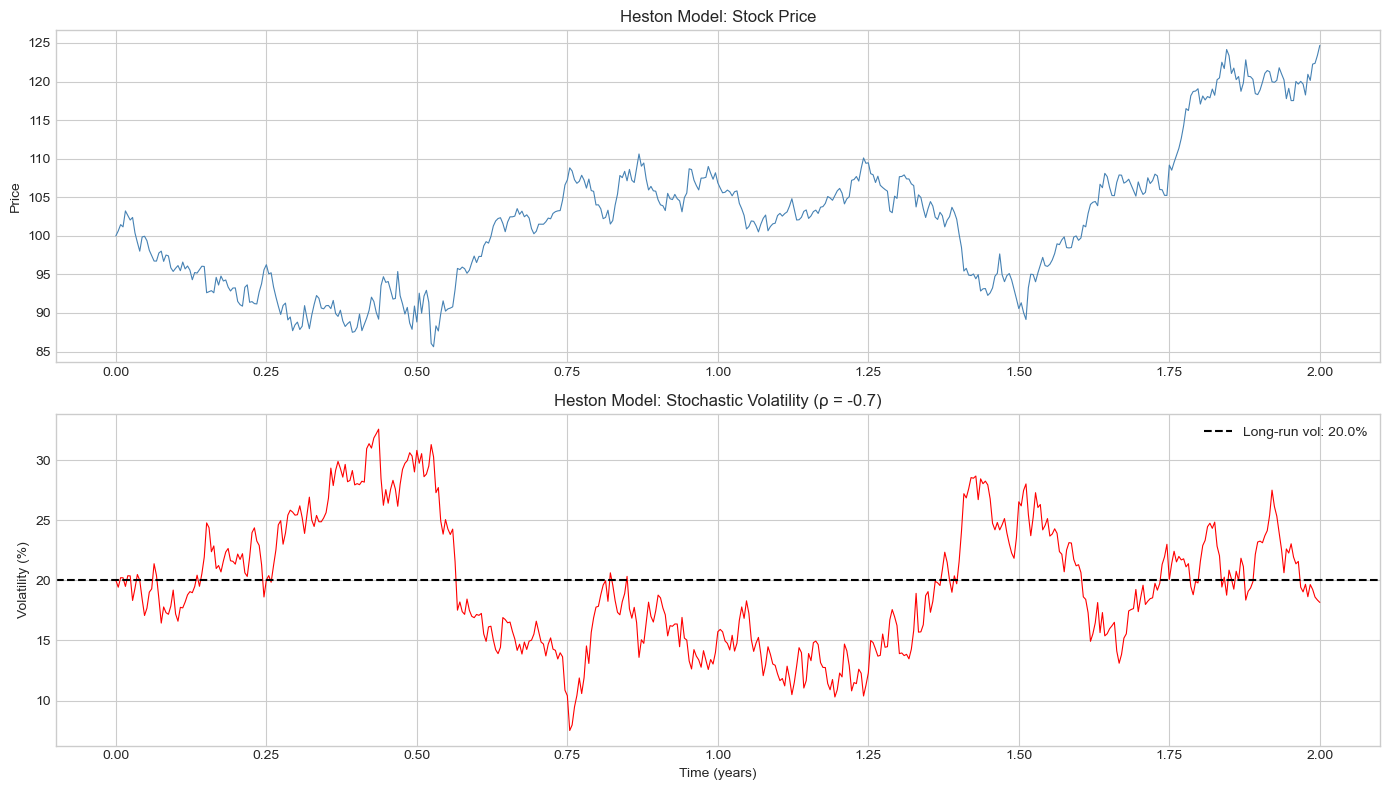

In [9]:
def simulate_heston(T, n_steps, S0, V0, mu, kappa, theta, sigma_v, rho, seed=None):
    """
    Simulate Heston stochastic volatility model using Euler discretization.
    """
    if seed is not None:
        np.random.seed(seed)
    
    dt = T / n_steps
    
    S = np.zeros(n_steps + 1)
    V = np.zeros(n_steps + 1)
    
    S[0] = S0
    V[0] = V0
    
    for i in range(n_steps):
        # Correlated Brownian motions
        Z1 = np.random.standard_normal()
        Z2 = np.random.standard_normal()
        W_S = Z1
        W_V = rho * Z1 + np.sqrt(1 - rho**2) * Z2
        
        # Ensure variance stays positive (full truncation)
        V_pos = max(V[i], 0)
        
        # Euler step
        S[i+1] = S[i] * np.exp((mu - 0.5*V_pos)*dt + np.sqrt(V_pos*dt)*W_S)
        V[i+1] = V[i] + kappa*(theta - V_pos)*dt + sigma_v*np.sqrt(V_pos*dt)*W_V
        V[i+1] = max(V[i+1], 0)  # Reflection
    
    return S, V

# Simulate Heston model
T = 2  # years
n_steps = 252 * 2  # daily
S0, V0 = 100, 0.04  # Initial price and variance
mu = 0.05
kappa = 3.0
theta = 0.04
sigma_v = 0.4
rho = -0.7

# Check Feller condition
feller = 2 * kappa * theta
print(f"Feller condition: 2κθ = {feller:.4f} vs σ²_v = {sigma_v**2:.4f}")
print(f"Condition {'satisfied' if feller > sigma_v**2 else 'VIOLATED'}")

S_heston, V_heston = simulate_heston(T, n_steps, S0, V0, mu, kappa, theta, sigma_v, rho, seed=42)

# Plot
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

t = np.linspace(0, T, n_steps + 1)

axes[0].plot(t, S_heston, color='steelblue', linewidth=0.8)
axes[0].set_ylabel('Price')
axes[0].set_title('Heston Model: Stock Price', fontsize=12)

axes[1].plot(t, np.sqrt(V_heston) * 100, color='red', linewidth=0.8)
axes[1].axhline(np.sqrt(theta) * 100, color='black', linestyle='--', 
                label=f'Long-run vol: {np.sqrt(theta)*100:.1f}%')
axes[1].set_xlabel('Time (years)')
axes[1].set_ylabel('Volatility (%)')
axes[1].set_title(f'Heston Model: Stochastic Volatility (ρ = {rho})', fontsize=12)
axes[1].legend()

plt.tight_layout()
plt.show()

## 5. SV with Leverage

### 5.1 Correlated Innovations

In discrete time, introduce correlation:

$$\text{Corr}(\epsilon_t, \eta_t) = \rho$$

Negative $\rho$ captures the leverage effect: negative returns → higher volatility.

In [11]:
def simulate_sv_leverage(n, mu, phi, sigma_eta, rho, seed=None):
    """SV model with leverage (correlated innovations)."""
    if seed is not None:
        np.random.seed(seed)
    
    h = np.zeros(n)
    y = np.zeros(n)
    
    # Correlated innovations
    for t in range(n):
        z1 = np.random.standard_normal()
        z2 = np.random.standard_normal()
        
        eps = z1
        eta = rho * z1 + np.sqrt(1 - rho**2) * z2
        
        if t == 0:
            h[t] = mu + sigma_eta * eta / np.sqrt(1 - phi**2)
        else:
            h[t] = mu + phi * (h[t-1] - mu) + sigma_eta * eta
        
        y[t] = np.exp(h[t] / 2) * eps
    
    return y, h

# Compare with and without leverage
n = 2000
mu, phi, sigma_eta = -10, 0.97, 0.15

y_no_lev, h_no_lev = simulate_sv(n, mu, phi, sigma_eta, seed=42)
y_lev, h_lev = simulate_sv_leverage(n, mu, phi, sigma_eta, rho=-0.5, seed=42)

# Compute correlation of returns with future volatility change
def leverage_correlation(y, h, lag=1):
    dh = np.diff(h[lag:])
    r = y[:-lag-1]
    return np.corrcoef(r, dh)[0, 1]

print("Leverage Effect in SV Models")
print("="*50)
print(f"Corr(r_t, Δh_{{t+1}}) without leverage: {leverage_correlation(y_no_lev, h_no_lev):.4f}")
print(f"Corr(r_t, Δh_{{t+1}}) with leverage (ρ=-0.5): {leverage_correlation(y_lev, h_lev):.4f}")

Leverage Effect in SV Models
Corr(r_t, Δh_{t+1}) without leverage: 0.0172
Corr(r_t, Δh_{t+1}) with leverage (ρ=-0.5): 0.0326


## 6. Comparison: SV vs GARCH

| Feature | GARCH | Stochastic Volatility |
|---------|-------|----------------------|
| Volatility dynamics | Deterministic given past | Random (own shock) |
| Estimation | MLE (straightforward) | Challenging (latent state) |
| Option pricing | Requires simulation | Closed-form (Heston) |
| Leverage | GJR-GARCH | Correlated innovations |
| Kurtosis | From GARCH dynamics | Can be more flexible |

## 7. Summary

### Key Takeaways

1. **Stochastic Volatility** has separate randomness for volatility
2. **Heston model** is the workhorse continuous-time SV model
3. **QML estimation** via log-squared returns transformation
4. **Leverage** captured by correlation between return and volatility innovations

### Preview: Session 8
**Rough volatility** - fractional Brownian motion in volatility.

## Exercises

1. Implement the **MCMC** (Markov Chain Monte Carlo) estimator for SV
2. Simulate Heston paths and price a European call option
3. Compare volatility forecasts from GARCH vs SV
4. Estimate SV model with leverage on S&P 500 returns

## References

1. Taylor, S. J. (1986). Modelling Financial Time Series. Wiley.
2. Harvey, A., Ruiz, E., & Shephard, N. (1994). Multivariate stochastic variance models. *Review of Economic Studies*, 61(2), 247-264.
3. Heston, S. L. (1993). A closed-form solution for options with stochastic volatility. *Review of Financial Studies*, 6(2), 327-343.